# 多输入神经元

聪明的读者会发现，上一节中所有神经元模型，我们的神经元都只有一个输入信号。

实际上，一个神经元会通过许多树突接受许多来自其他神经元轴突的输入信号，然后这些信号各自加权后求和，最终变化为膜电压。

SNN中的加权求和的过程与传统ANN中的并没有区别，因此，我们可以直接使用pytorch中的全连接层用于模拟加权求和，然后将加权求和后的结果输入到脉冲神经元模型中即可。

In [1]:
# import
import torch
import torch.nn as nn
from torch.nn import functional as F
from spikingjelly.activation_based import neuron
from spikingjelly import visualizing
from matplotlib import pyplot as plt

我们首先仿真一个4输入的神经元模型，我们通过nn.Linear来实现加权求和，再将加权求和后的结果输入到脉冲神经元层

In [35]:
# 生成一个长度为4的向量
x = torch.rand(size=[4])
print(f"输入 = {x}")
# 新建一个全连接层
linear_layer = nn.Linear(in_features=4, out_features=1, bias=False)
print("权重 = ", linear_layer.weight) # 输出权重
# 新建一个脉冲神经元层
if_layer = neuron.IFNode()

y = linear_layer(x) # 先通过全连接层实现加权求和
if_layer(y) # 将加权求和后的结果输入脉冲神经元层
print(f"脉冲神经元膜电压 = {if_layer.v}") # 输出脉冲神经元膜电压

输入 = tensor([0.8207, 0.2316, 0.6463, 0.6736])
权重 =  Parameter containing:
tensor([[-0.1251, -0.1470,  0.0496, -0.4917]], requires_grad=True)
脉冲神经元膜电压 = tensor([-0.4359], grad_fn=<DifferentiableGraphBackward>)


我们可以来自行验证结果，将输入信号与权重进行点积，最后会发现结果就是神经元的膜电压。

例如，输入信号向量为[4.9141, 2.7951, 4.7442, 0.8508]，权重向量为[0.3059, -0.2457, -0.2957, 0.4839]，最终膜电压为-0.1745

总结一下，我们使用pytorch中的nn.Linear全连接层来实现加权求和过程，然后将加权求和后的结果输入脉冲神经元层，判断膜电压是否大于阈值，并产生脉冲。

输入 = tensor([0.4870, 0.0997, 0.8498, 0.0593])
权重 =  Parameter containing:
tensor([[ 0.4239,  0.4399,  0.4290, -0.1096]], requires_grad=True)
[tensor([0.], grad_fn=<sigmoidBackward>), tensor([1.], grad_fn=<sigmoidBackward>), tensor([0.], grad_fn=<sigmoidBackward>), tensor([1.], grad_fn=<sigmoidBackward>), tensor([0.], grad_fn=<sigmoidBackward>), tensor([1.], grad_fn=<sigmoidBackward>), tensor([0.], grad_fn=<sigmoidBackward>), tensor([1.], grad_fn=<sigmoidBackward>), tensor([0.], grad_fn=<sigmoidBackward>), tensor([1.], grad_fn=<sigmoidBackward>), tensor([0.], grad_fn=<sigmoidBackward>), tensor([1.], grad_fn=<sigmoidBackward>), tensor([0.], grad_fn=<sigmoidBackward>), tensor([1.], grad_fn=<sigmoidBackward>), tensor([0.], grad_fn=<sigmoidBackward>), tensor([1.], grad_fn=<sigmoidBackward>), tensor([0.], grad_fn=<sigmoidBackward>), tensor([1.], grad_fn=<sigmoidBackward>), tensor([0.], grad_fn=<sigmoidBackward>), tensor([1.], grad_fn=<sigmoidBackward>)]
[tensor([0.6083], grad_fn=<Differentia

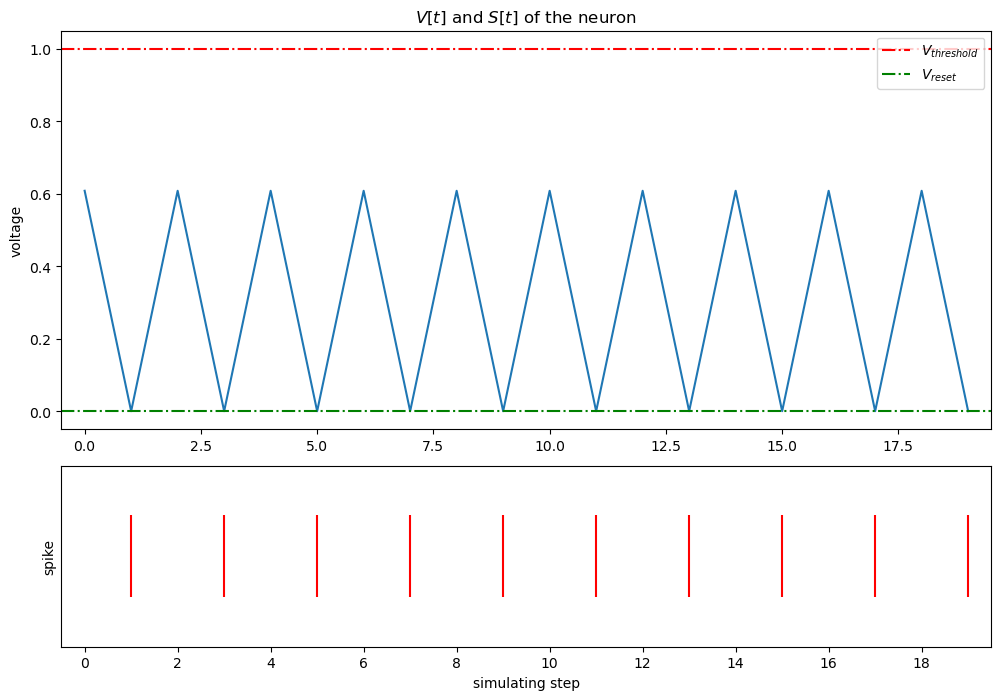

In [68]:
# 生成一个长度为4的向量
x = torch.rand(size=[4])
print(f"输入 = {x}")
# 新建一个全连接层
linear_layer = nn.Linear(in_features=4, out_features=1, bias=False)
print("权重 = ", linear_layer.weight) # 输出权重
# 复位脉冲神经元层
if_layer.reset()

T = 20
s_list = [] # 记录输出脉冲
v_list = [] # 记录输出膜电压
# 按照时间顺序逐步进行
for t in range(T):
    y = linear_layer(x) # 先通过全连接层模拟加权求和
    s_list.append(if_layer(y)) # 将加权求和后的结果输入脉冲神经元层
    v_list.append(if_layer.v)

print(s_list) # 输出脉冲
print(v_list) # 输出膜电压

dpi = 100
figsize = (12, 8)
visualizing.plot_one_neuron_v_s(torch.cat(v_list).detach().numpy(), torch.cat(s_list).detach().numpy(), v_threshold=if_layer.v_threshold,
                                v_reset=if_layer.v_reset,
                                figsize=figsize, dpi=dpi)
plt.show()

上面我们的脉冲神经网络层if_layer只有1个神经元，如果我们希望有多个神经元输出，那我们需要调节if_layer前的全连接层linear_layer中的输出神经元数量。因为脉冲神经元层的神经元数量是由前一层的神经元数量决定的。

例如，当我们希望生成一个10输入3输出的脉冲神经元层，那么就需要修改全连接层linear_layer的参数`in_features=10`以及`out_features=3`

输入 = tensor([0.7592, 0.7624, 0.3849, 0.8033, 0.8596, 0.9028, 0.7756, 0.1528, 0.6186,
        0.1167])
权重 =  Parameter containing:
tensor([[ 1.7404e-01,  2.3748e-02,  8.8470e-02,  1.4896e-01,  1.6290e-01,
         -2.6387e-01, -6.5148e-05, -2.0949e-01, -2.9482e-01, -2.7508e-01],
        [ 1.5172e-01, -2.6602e-01,  2.1748e-01,  2.8692e-01,  2.7649e-01,
          5.3322e-04, -7.4024e-03, -4.1608e-02,  2.1658e-01,  2.9824e-01],
        [ 3.0818e-01, -1.7455e-01,  2.9994e-01,  2.3743e-02,  2.0361e-02,
          9.2077e-02, -1.3603e-02,  1.7773e-01, -2.9497e-02,  2.9832e-01]],
       requires_grad=True)


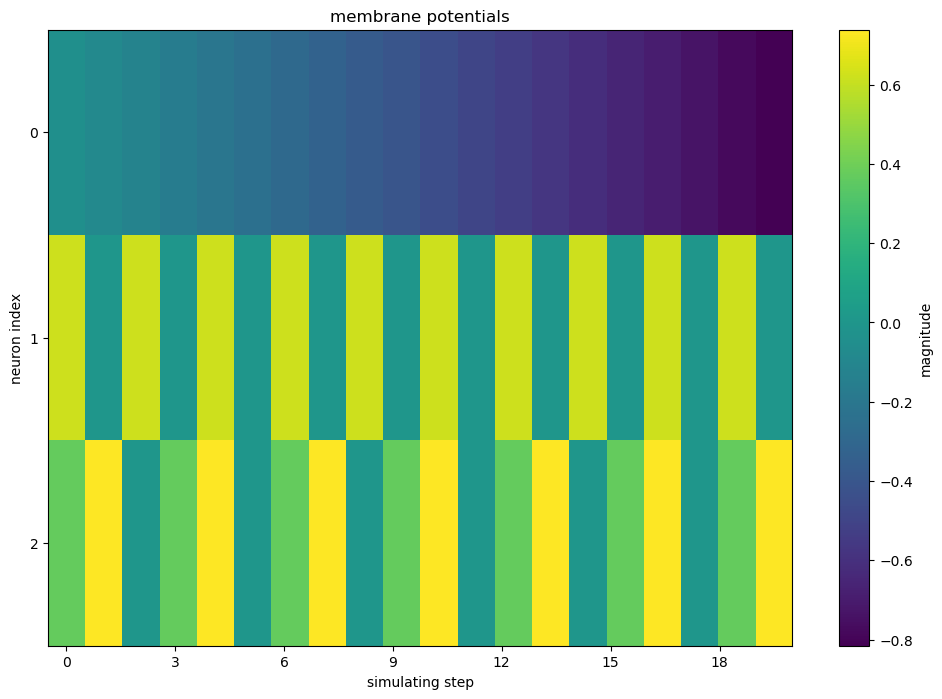

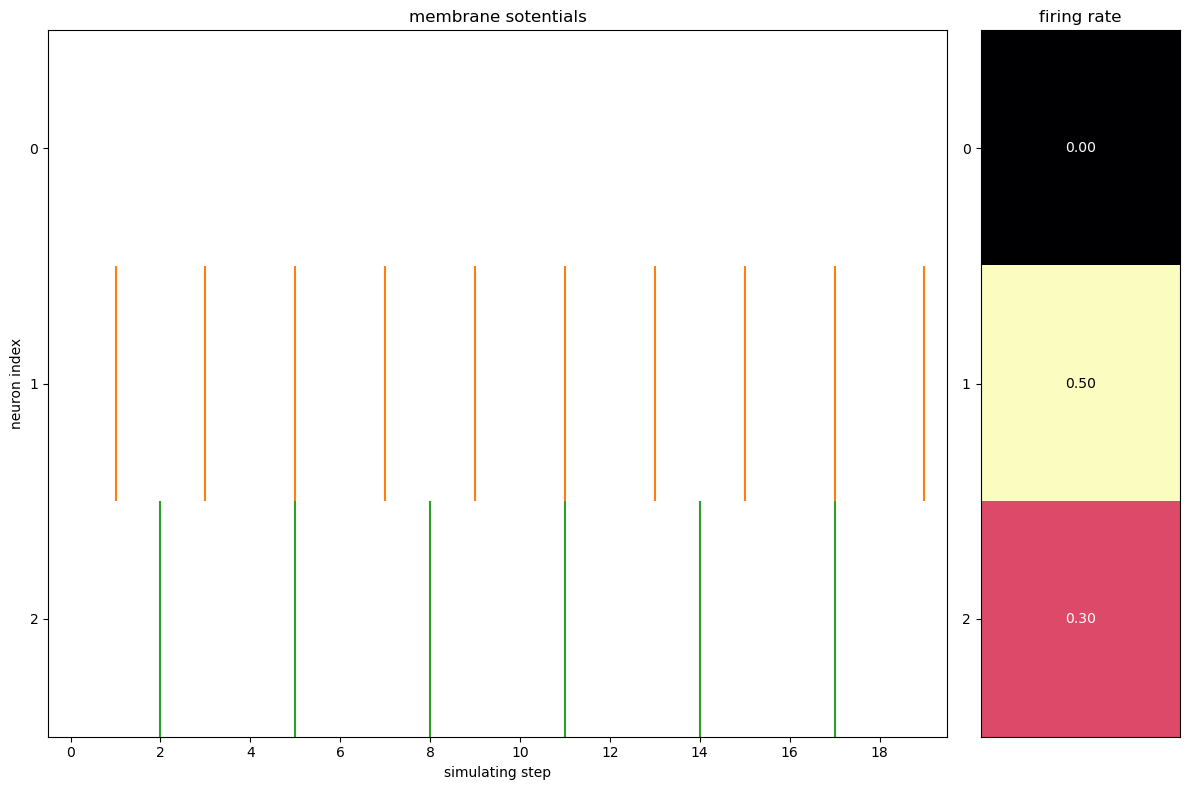

In [ ]:
# 生成一个长度为4的向量
x = torch.rand(size=[10])
print(f"输入 = {x}")
# 新建一个全连接层
linear_layer = nn.Linear(in_features=10, out_features=3, bias=False)
print("权重 = ", linear_layer.weight) # 输出权重
# 复位脉冲神经元层
if_layer.reset()

T = 20
s_list = [] # 记录输出脉冲
v_list = [] # 记录输出膜电压
# 按照时间顺序逐步进行
for t in range(T):
    y = linear_layer(x) # 先通过全连接层模拟加权求和
    s_list.append(if_layer(y).unsqueeze(0)) # 将加权求和后的结果输入脉冲神经元层
    v_list.append(if_layer.v.unsqueeze(0))

dpi = 100
figsize = (12, 8)
visualizing.plot_2d_heatmap(array=torch.cat(v_list).detach().numpy(), title='membrane potentials', xlabel='simulating step',
                            ylabel='neuron index', int_x_ticks=True, x_max=T, figsize=figsize, dpi=dpi)

visualizing.plot_1d_spikes(spikes=torch.cat(s_list).detach().numpy(), title='membrane sotentials', xlabel='simulating step',
                        ylabel='neuron index', figsize=figsize, dpi=dpi)
plt.show()